In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..")))
import pysgmcmc as pg
import matplotlib.pyplot as plt

## 1. Training Bayesian Models

One major application area of Stochastic Gradient Markov-Chain Monte Carlo methods is *Bayesian learning*. In the following cells, we showcase an example of training a Bayesian Neural Network on a simple target function. Note that all our optimizers are implemented in *keras*. This means we have flexibility with respect to our computational backend and can export them to native optimizers for multiple libraries such as *tensorflow*.

### Setting up an example target function

We start by introducing a target function and sampling training and test data for our model. 
As a target function, we use a simple 1-d *sinc* variant.

In [2]:
from pysgmcmc.diagnostics.objective_functions import sinc

def init_random_uniform(lower, upper, n_points, rng=None):
    if rng is None:
        rng = np.random.RandomState(np.random.randint(0, 10000))

    n_dims = lower.shape[0]

    return np.array(
        [rng.uniform(lower, upper, n_dims) for _ in range(n_points)]
    )


n_datapoints = 100
x_train = init_random_uniform(
    lower=np.zeros(1), upper=np.ones(1), n_points=n_datapoints
)

y_train = sinc(x_train)

x_test = np.linspace(0, 1, 100)[:, None]
y_test = sinc(x_test)


### Setting up our network

Next, we set up our Bayesian Neural Network with corresponding SGMCMC sampler that serves as optimizer. 

Then, we train our Bayesian Neural Network on our training data and extract $100$ weights samples from this network using our SGHMC sampler. 
We use these $100$ weight samples to predict on our test data and collect mean and variance of these predictions.

We produce a plot of our true *sinc* function against the predictions of our networks (with uncertainty bounds).

Using TensorFlow backend.


Epoch 1/1
13000/13000 [==============================] - 16s 1ms/step - loss: 25.5164 - mean_absolute_error: 0.9304 - mean_squared_error: 2.1202


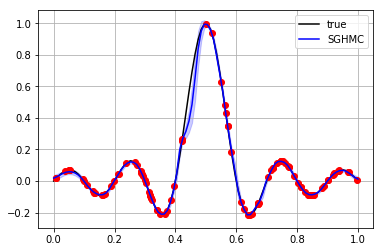

In [3]:
from pysgmcmc.models.bayesian_neural_network import BayesianNeuralNetwork
from pysgmcmc.optimizers.sghmc import SGHMC

model = BayesianNeuralNetwork(optimizer=SGHMC, n_nets=100, learning_rate=1e-02)
model.train(x_train, y_train)

prediction_mean, prediction_variance = model.predict(x_test)
prediction_std = np.sqrt(prediction_variance)
plt.grid()

plt.plot(x_test[:, 0], y_test, label="true", color="black")
plt.plot(x_train[:, 0], y_train, "ro")

plt.plot(x_test[:, 0], prediction_mean, label=model.optimizer.__class__.__name__, color="blue")
plt.fill_between(x_test[:, 0], prediction_mean + prediction_std, prediction_mean - prediction_std, alpha=0.2, color="blue")

plt.legend()
plt.show()


Epoch 1/1
13000/13000 [==============================] - 19s 1ms/step - loss: 29.7722 - mean_absolute_error: 0.9297 - mean_squared_error: 2.1210


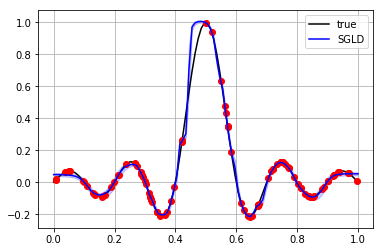

In [4]:
from pysgmcmc.optimizers.sgld import SGLD
from pysgmcmc.models.bayesian_neural_network import BayesianNeuralNetwork


model = BayesianNeuralNetwork(optimizer=SGLD, n_nets=100, learning_rate=1e-03)
model.train(x_train, y_train)

prediction_mean, prediction_variance = model.predict(x_test)
prediction_std = np.sqrt(prediction_variance)
plt.grid()

plt.plot(x_test[:, 0], y_test, label="true", color="black")
plt.plot(x_train[:, 0], y_train, "ro")

plt.plot(x_test[:, 0], prediction_mean, label=model.optimizer.__class__.__name__, color="blue")
plt.fill_between(x_test[:, 0], prediction_mean + prediction_std, prediction_mean - prediction_std, alpha=0.2, color="blue")

plt.legend()
plt.show()

## Standalone samplers

For each of our optimizers, we also provide an interface as convenient standalone sampler. 
Using this interface we can study samplers detached from actual learning applications on standard sampling benchmarks.

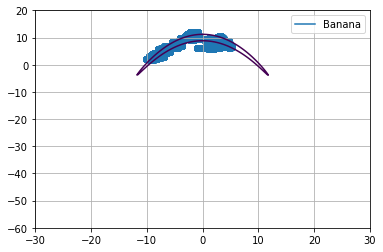

In [5]:
from keras import backend as K
from pysgmcmc.samplers.optimizer_sghmc import SGHMCSampler
from pysgmcmc.diagnostics.objective_functions import (
    banana_log_likelihood, to_negative_log_likelihood
)
from itertools import islice

#  Banana Contour {{{ #
def banana_plot():
    x = np.arange(-25, 25, 0.05)
    y = np.arange(-50, 20, 0.05)
    xx, yy = np.meshgrid(x, y, sparse=True)
    densities = np.asarray([np.exp(banana_log_likelihood((x, y))) for x in xx for y in yy])
    f, ax = plt.subplots(1)
    xdata = [1, 4, 8]
    ydata = [10, 20, 30]
    ax.contour(x, y, densities, 1, label="Banana")
    ax.plot([], [], label="Banana")
    ax.legend()
    ax.grid()

    ax.set_ylim(ymin=-60, ymax=20)
    ax.set_xlim(xmin=-30, xmax=30)

#  }}} Banana Contour #

banana_nll = to_negative_log_likelihood(banana_log_likelihood)
params = [K.variable(0.0), K.variable(6.0)]
loss = banana_nll(params)

n_samples = 10 ** 4

sampler = SGHMCSampler(lr=0.01, params=params, loss=loss, burn_in_steps=3000)

samples = np.asarray([
    sample for _, sample in islice(sampler, n_samples)
])

banana_plot()
plt.scatter(samples[:, 0], samples[:, 1])


### Diagnostics for samplers

As explained before, studying samplers and evaluating their behaviour on a given problem instance is a frequent use case for our standalone sampler module. To make this task easier, we provide an interface to *pymc3* which already has a lot of state-of-the-art sampler diagnostics and plotting facilities implemented. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3cf8bbaf60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f3cf8c05dd8>], dtype=object)

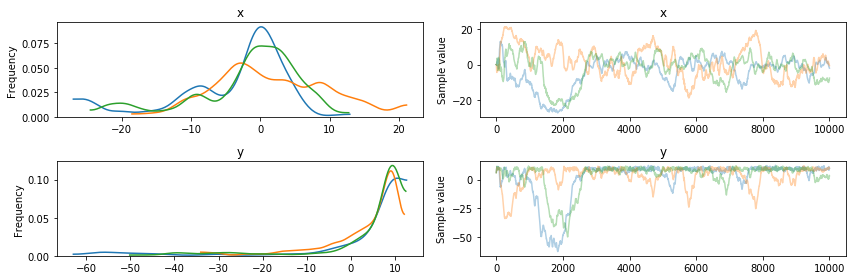

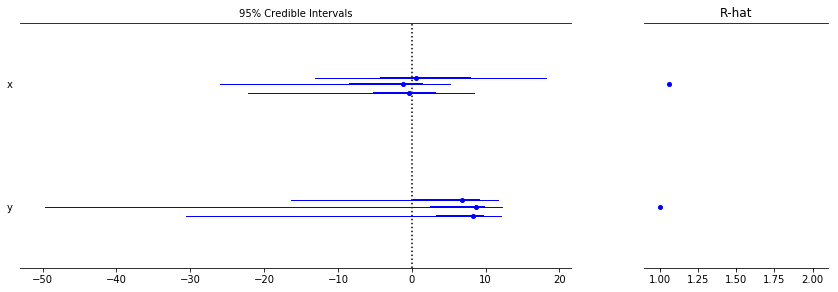

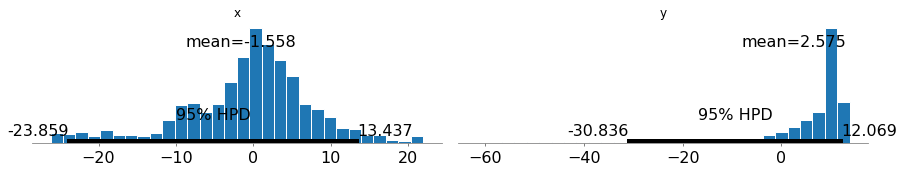

In [8]:
from pysgmcmc.diagnostics.sample_chains import PYSGMCMCTrace
from pymc3.backends.base import MultiTrace
from pymc3.plots import (
    traceplot, autocorrplot, forestplot, plot_posterior
)

traces = []

for i in range(3):
    params = [K.variable(0.0, name="x"), K.variable(6.0, name="y")]
    loss = banana_nll(params)

    n_samples = 10 ** 4

    sampler = SGHMCSampler(lr=0.2, params=params, loss=loss, burn_in_steps=3000)

    samples = np.asarray([
        sample for _, sample in islice(sampler, n_samples)
    ])
    
    traces.append(PYSGMCMCTrace(chain_id=i, samples=samples, varnames=("x", "y")))

multitrace = MultiTrace(traces)

traceplot(multitrace)
autocorrplot(multitrace)
forestplot(multitrace)
plot_posterior(multitrace)
